In [2]:
!pip install pandas

  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)


You should consider upgrading via the 'C:\Users\imami\OneDrive\Bureau\projet fil rouge\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd

In [4]:
df=pd.read_csv("C:/Users/imami/OneDrive/Bureau/projet fil rouge/Projet_Fil_Rouge_Telecom_Diag/Projet_Fil_Rouge_Telecom_Diag/Data/OT/ot_data_V6_douai_v2.csv")

In [5]:
l=len('Description de l’activité attendue et/ou explication du problème :')
df['ACTIVITES']=df['ACTIVITES'].str[l+1:]

In [6]:
import re

# Input text
text = """23.01.2023 08:50:20 A______ :    . Symptôme: NOMBREUX DEFAUT SERTISSAGES SUR LA TETE 2 RIVKLE    . Cause: SURPRESSEUR HS    . Solution: REPRISE DES POINTS DE DEPOSE RIVKLE    NOK   REFAIT ETALONNAGE CAPTEUR COURSE DE SERTISSAGE    NOK REM PLACEMENT DE LA TETE DE SERTISSAGE NOK   REMPLACEMENT DU SURPRESSEUR PAR L'EQUIPE DE NUIT    OK    . Validation: OK"""

# Regular expression pattern
pattern = r"""
    . Symptôme: (?P<symptome>.*?)    \.     # Match "Symptôme" section
    . Cause: (?P<cause>.*?)    \.         # Match "Cause" section
    . Solution: (?P<solution>.*?)    \.   # Match "Solution" section
    . Validation: (?P<validation>.*)      # Match "Validation" section
"""

# Compile the regex pattern with verbose flag
regex = re.compile(pattern, re.VERBOSE)

# Apply regex to find the groups
match = regex.search(text)
if match:
    symptome = match.group("symptome")
    cause = match.group("cause")
    solution = match.group("solution")
    validation = match.group("validation")

    # Print the results
    print("Symptôme:", symptome)
    print("Cause:", cause)
    print("Solution:", solution)
    print("Validation:", validation)
else:
    print("No match found!")

Symptôme:  NOMBREUX DEFAUT SERTISSAGES SUR LA TETE 2 RIVKLE    
Cause:  SURPRESSEUR HS    
Solution:  REPRISE DES POINTS DE DEPOSE RIVKLE    NOK   REFAIT ETALONNAGE CAPTEUR COURSE DE SERTISSAGE    NOK REM PLACEMENT DE LA TETE DE SERTISSAGE NOK   REMPLACEMENT DU SURPRESSEUR PAR L'EQUIPE DE NUIT    OK    
Validation:  OK


In [7]:
symptome_list=[]
cause_list=[]
solution_list=[]
validation_list=[]

for text in df['COMMENT_OT']:
  match = regex.search(text)
  if match:
    symptome = match.group("symptome")
    cause = match.group("cause")
    solution = match.group("solution")
    validation = match.group("validation")

    #append the result
    symptome_list.append(symptome)
    cause_list.append(cause)
    solution_list.append(solution)
    validation_list.append(validation)

ot_data={
    'symptome':symptome_list,
    'cause':cause_list,
    'solution':solution_list,
    'validation': validation
}
df_ot = pd.DataFrame(ot_data)

In [8]:
df_ot.count()

symptome      2827
cause         2827
solution      2827
validation    2827
dtype: int64

In [9]:
f = open("C:/Users/imami/OneDrive/Bureau/projet fil rouge/Projet_Fil_Rouge_Telecom_Diag/Projet_Fil_Rouge_Telecom_Diag/Data/Doc_Fournisseur/raw_text.txt", "r",  encoding="utf-8")
raw_text=''
for x in f:
    raw_text+=x
f.close()

In [10]:
symptome_list=[]
cause_list=[]
solution_list=[]

pattern = r"(?P<title>\d+\.\d+\.\d+\.\d+ [^\n]+)\s*Cause:\s*(?P<cause>[^R]+)\s*Remedy:\s*(?P<remedy>[^\n]+(?:\n\s*•[^\n]+)*)"

matches = re.finditer(pattern, raw_text)

for match in matches:
    symptome_list.append(match.group("title"))
    cause_list.append(match.group("cause").strip())
    solution_list.append(match.group("remedy").strip())

doc_data={
    'symptome':symptome_list,
    'cause':cause_list,
    'solution':solution_list
}
df_doc = pd.DataFrame(doc_data)

In [11]:
df_doc.head()

,symptome,cause,solution
0,3.1.1.1 ACAL-000 Fail to run DETECT Motn,TheAccuCal2Motionfailedtorun. TheAccuCal2motio...,Clear all the errors before executing AccuCal2.
1,3.1.1.2 ACAL-001 Robot is not ready.,Therobotisnotready. Thesystemcannotissuemotion...,"Clear all faults, then retry the operation."
2,3.1.1.3 ACAL-002 Fail to fit circle.,AccuCal2cannotconvergewithinthesetthreshold.,Perform the following:\n• Increase the number ...
3,3.1.1.4 ACAL-003 Contact before search.,Therobotisincontactwiththepartbeforestartingas...,Reteach the starting position.
4,3.1.1.5 ACAL-004 No contact detected.,NocontactwasmadeduringtheAccuCal2motion.,Makesurethesensorandsoftwareareinstalledcorrec...


In [12]:
df_doc.drop_duplicates(subset=['symptome'], inplace=True)

In [13]:
df_doc.count()

symptome    7748
cause       7748
solution    7748
dtype: int64

In [14]:
df_ot_v1 = df_ot.drop('validation', axis=1)
df_total=pd.concat([df_ot_v1,df_doc],axis=0)

In [15]:
df_total.count()

symptome    10575
cause       10575
solution    10575
dtype: int64

# Generate a knowledge graph


## Problématique

Le fait que notre dataset de triplets `(symptôme, cause, solution)` soit généré à partir du **parsing de documents fournisseurs** et des **ordres de travail** entraîne un problème :  

- Les noeuds du graphe sont **uniques** et isolés.  
- En conséquence, le graphe de connaissance que nous construirons sera un **graphe sparse** avec **peu d’interconnexions** entre les entités.  

---

## Solutions pour Remédier à la Sparsité

1. **Utiliser des mesures de similarité sémantique** :  
   - Identifier et combiner les noeuds qui présentent un certain **overlap** dans leurs significations ou contenus.
   - Par exemple :  
     - Noeuds "Connexion lente" et "Internet lent" peuvent être fusionnés en un noeud commun "Problème de réseau".

2. **Appliquer un modèle de clustering** :  
   - Grouper les noeuds en **clusters** pour rassembler des entités similaires.
   - Par exemple :  
     - Problèmes "Connexion instable" et "Wi-Fi intermittent" peuvent être regroupés sous un cluster de type "Problèmes réseau".

3. **Utiliser des algorithmes de détection de communautés** :  
   - Identifier les **relations implicites** ou **groupes d'entités fortement connectées** dans le graphe.  
---

Ces approches permettront d’enrichir et de densifier le graphe, le rendant **moins sparse** et **plus interconnecté**, facilitant ainsi les analyses et les requêtes.  

In [16]:
!pip install neo4j

  Using cached neo4j-5.28.1-py3-none-any.whl (312 kB)


You should consider upgrading via the 'C:\Users\imami\OneDrive\Bureau\projet fil rouge\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [17]:
from neo4j import GraphDatabase

In [28]:
#creating the graph database

uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(uri, auth=(username, password))

def create_graph(df):
    with driver.session(database="renault") as session:
        for index, row in df.iterrows():
            symptome = row['symptome']
            cause = row['cause']
            solution = row['solution']

            # Create Nodes and Relationships
            session.run("""
                MERGE (s:Symptome {name: $symptome})
                MERGE (c:Cause {name: $cause})
                MERGE (r:Solution {name: $solution})
                MERGE (s)-[:CAUSES]->(c)
                MERGE (s)-[:TREATED_BY]->(r)
                MERGE (c)-[:TREATED_BY]->(r)
            """, symptome=symptome, cause=cause, solution=solution)

create_graph(df_total)
driver.close()


this is the first itteration of the graph that looks sparse due to the problems cited before

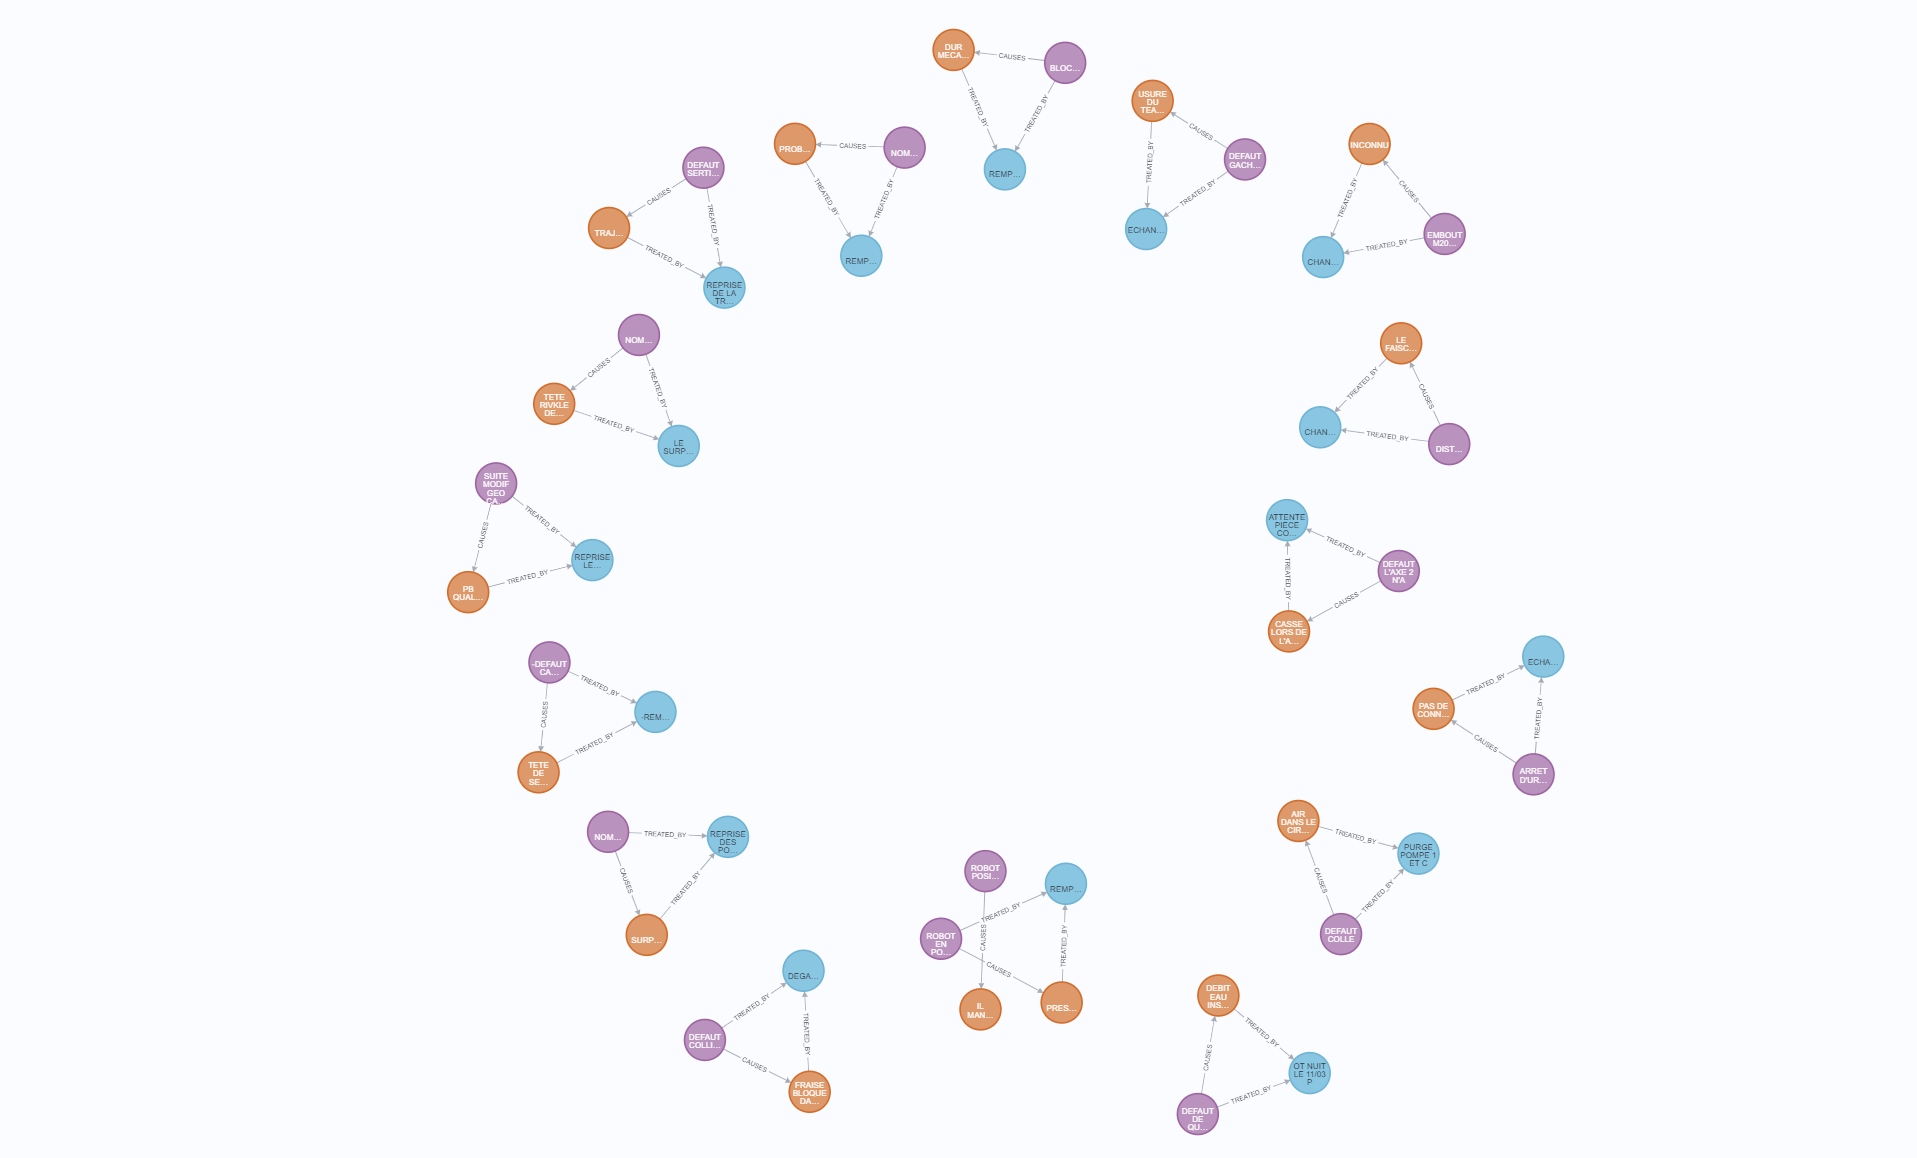

We will try to compute semantic similarity between symptome nodes to reduce the sparcity of the graph

In [18]:
!pip install sentence-transformers

     -------------------------------------- 345.7/345.7 KB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 10.4/10.4 MB 1.6 MB/s eta 0:00:00
  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
  Using cached torch-2.6.0-cp39-cp39-win_amd64.whl (204.1 MB)
     ---------------------------------------- 2.7/2.7 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 481.4/481.4 KB 3.3 MB/s eta 0:00:00
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-win_amd64.whl (162 kB)
     -------------------------------------- 194.4/194.4 KB 3.9 MB/s eta 0:00:00
  Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached mpmath

You should consider upgrading via the 'C:\Users\imami\OneDrive\Bureau\projet fil rouge\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [23]:
!pip install langchain_community

     ---------------------------------------- 2.5/2.5 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 44.4/44.4 KB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 8.0 MB/s eta 0:00:00
     -------------------------------------- 358.2/358.2 KB 3.7 MB/s eta 0:00:00
  Using cached httpx_sse-0.4.0-py3-none-any.whl (7.8 kB)
     -------------------------------------- 443.2/443.2 KB 4.6 MB/s eta 0:00:00
  Using cached sqlalchemy-2.0.40-cp39-cp39-win_amd64.whl (2.1 MB)
     -------------------------------------- 433.9/433.9 KB 5.4 MB/s eta 0:00:00
  Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
  Using cached propcache-0.3.1-cp39-cp39-win_amd64.whl (45 kB)
  Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
     ---------------------------------------- 93.5/93.5 KB 5.2 MB/s eta 0:00:00
     -------------

You should consider upgrading via the 'C:\Users\imami\OneDrive\Bureau\projet fil rouge\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
# for each symptome in the database generate the embedding
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model="all-MiniLM-L6-v2"
embbedings= HuggingFaceBgeEmbeddings(model_name=model)
text = "this is a test sentence."

emb=embbedings.embed_query(text)
print(emb)
len(emb)

C:\Users\imami\AppData\Local\Temp\ipykernel_47592\2349904262.py:5: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embbedings= HuggingFaceBgeEmbeddings(model_name=model)
c:\Users\imami\OneDrive\Bureau\projet fil rouge\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.0020460542291402817, 0.13609443604946136, 0.039100684225559235, 0.05278882756829262, 0.024239160120487213, 0.07189047336578369, 0.04403393343091011, -0.04320892319083214, 0.021727288141846657, 0.03374071046710014, 0.09213870018720627, -0.05743074789643288, -0.005065202247351408, 0.015119721181690693, 0.09486768394708633, -0.0214402936398983, -0.014526359736919403, -0.04264303669333458, -0.036493267863988876, 0.009080390445888042, 0.11434401571750641, 0.0741075873374939, 0.017102308571338654, -0.009110413491725922, -0.021960558369755745, -0.0014445839915424585, -0.026737766340374947, -0.02711832895874977, 0.11948095262050629, -0.0394931398332119, -0.02045113407075405, 0.016485676169395447, 0.0357232391834259, 0.06152486428618431, 0.04143768921494484, 0.019488148391246796, 0.05194563791155815, 0.012529161758720875, 0.0705190896987915, -0.028083186596632004, 0.002822208683937788, -0.0682535395026207, 0.0038219201378524303, 0.02343253791332245, 0.010396032594144344, -0.01366720348596572

384

In [25]:
symptome_embedding=[]
for symptome in df_total['symptome']:
    emb=embbedings.embed_query(symptome)
    symptome_embedding.append(emb)

df_total['symptome_embedding']=symptome_embedding
df_total['symptome_embedding'].head(5)

0    [-0.011123289354145527, 0.03494686633348465, -...
1    [0.0151600930839777, 0.08196549117565155, -0.0...
2    [-0.03745705634355545, 0.06859814375638962, 0....
3    [-0.10396202653646469, 0.05229264497756958, -0...
4    [-0.061274029314517975, 0.10685642063617706, 0...
Name: symptome_embedding, dtype: object

In [26]:
df_total.head()

,symptome,cause,solution,symptome_embedding
0,"ROBOT EN POSITION DE SOUDURE, DEFAUT ROBOT EN...",PRESENCE DE LIQUIDE DE REFROIDISSEMENT ENTRE ...,REMPLACEMENT DU FAISCEAU PLUS PASSAGE DU FIL ...,"[-0.011123289354145527, 0.03494686633348465, -..."
1,DEFAUT DE QUALITE DE SOUDURE,DEBIT EAU INSUFFISANT 5.15L,OT NUIT LE 11/03 POUR VERIF BOUCHON D'EAU NOK...,"[0.0151600930839777, 0.08196549117565155, -0.0..."
2,DEFAUT COLLE,AIR DANS LE CIRCUIT,PURGE POMPE 1 ET CIRCUIT NETTOYAGE BUSE ESSAI...,"[-0.03745705634355545, 0.06859814375638962, 0...."
3,ARRET D'URGENCE FS3,PAS DE CONNEXION AVEC AUTOMATE,ECHANGE CARTE PMCIA ECHANGE CARTE UC ECHA...,"[-0.10396202653646469, 0.05229264497756958, -0..."
4,DEFAUT L'AXE 2 N'ATTEINT PAS SON ZERO (E8.5 1),"CASSE LORS DE L'AUTRE EQUIPE, OUTIL COINCE DAN...",ATTENTE PIECE COMMANDER LE VENDREDI 16/06/2023,"[-0.061274029314517975, 0.10685642063617706, 0..."


In [29]:
#add the embedding to the graph database
uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(uri, auth=(username, password))

def add_embeddings_graph(df):
     
     with driver.session(database="renault") as session:
          for index, row in df.iterrows():
               symptome = row['symptome']
               embedding = row['symptome_embedding']

               # Create Nodes and Relationships
               session.run("""
    MATCH (s:Symptome) 
    WHERE s.name = $symptome
    SET s.embedding = $embedding
    """, symptome=symptome, embedding=embedding)

add_embeddings_graph(df_total)
driver.close()
          

before computing for similarities to add relationships based on similare nodes let us see if the similarity process yields any plausible result

In [30]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(uri, auth=(username, password))

#performe the similarity search
def check_semantic_relationships():
    with driver.session(database="renault") as session:

         # Step 1: Check if the graph already exists and drop it
        graph_exists = session.run("CALL gds.graph.exists('symptom_graph') YIELD exists RETURN exists").single()["exists"]
        
        if graph_exists:
            session.run("CALL gds.graph.drop('symptom_graph')")

        # Step 2: Project the graph
        session.run("""
            CALL gds.graph.project(
        'symptom_graph',
        {
            Symptome: {
            properties: ['embedding']
            }
        },
        '*'
        )
        """)

        # Step 3: Perform Node Similarity with knn
        session.run("""
                CALL gds.knn.write('symptom_graph', {
                topK: 5, 
                nodeProperties: ['embedding'],
                randomSeed: 42,
                concurrency: 1,
                sampleRate: 0.3,
                deltaThreshold: 0.0,
                writeRelationshipType: 'SIMILAR_TO',
                writeProperty: 'similarityScore'
                })
                YIELD nodesCompared, relationshipsWritten
            """)
        result_1 = session.run("""
                MATCH (s1:Symptome)-[r:SIMILAR_TO]->(s2:Symptome)
                WHERE r.similarityScore > 0.8 and r.similarityScore < 0.9
                RETURN count(r) as total, 
                min(r.similarityScore) as min_score,
                max(r.similarityScore) as max_score,
                avg(r.similarityScore) as avg_score""")
        
        for record in result_1:
            total = record["total"]
            min_score = record["min_score"]
            max_score = record["max_score"]
            avg_score = record["avg_score"]
            print(f"Total Relationships: {total}")
            print(f"Min Similarity Score: {min_score}")
            print(f"Max Similarity Score: {max_score}")
            print(f"Avg Similarity Score: {avg_score}")
        
        result_2 = session.run("""
                MATCH (s1:Symptome)-[sim:SIMILAR_TO]->(s2:Symptome)
                WHERE sim.similarityScore > 0.8 and sim.similarityScore < 0.9
                RETURN s1.name AS symptom1, s2.name AS symptom2, sim.similarityScore AS score
                ORDER BY sim.similarityScore DESC
                LIMIT 10
                """)
        
        print("\nTop 10 Similar Symptom Pairs:")
        print("-" * 50)
        print(f"{'Symptom 1':<20} {'Symptom 2':<20} {'Similarity Score':<15}")
        print("-" * 50)

        for record in result_2:
            symptom1 = record["symptom1"]
            symptom2 = record["symptom2"]
            score = record["score"]
            print(f"{symptom1:<20} {symptom2:<20} {score:.4f}")

        # Step 4: Drop the graph after use
        session.run("""
                CALL gds.graph.drop('symptom_graph') YIELD graphName

                MATCH ()-[r:SIMILAR_TO]->() 
                DELETE r
""")

# Execute
check_semantic_relationships()
driver.close()

Total Relationships: 28849
Min Similarity Score: 0.8000010447812225
Max Similarity Score: 0.8999907856921263
Avg Similarity Score: 0.8511281466723742

Top 10 Similar Symptom Pairs:
--------------------------------------------------
Symptom 1            Symptom 2            Similarity Score
--------------------------------------------------
 ROBOT R3 BLOQUE DANS LE NETTOYEUR BUSE   ROBOT BLOQUE DANS LE TM COTE HCB  0.9000
 PAS D'AMENEE GOUJON + PAS DE SOUDURE      DEFAUT SOUDURE GOUJON  0.9000
DEFAUT SOUDURE GOUJON   PAS D'AMENEE GOUJON + PAS DE SOUDURE      0.9000
3.18.3.284 SEAL-360 Disp shutoff: TP E-stop (E%s) 3.18.3.285 SEAL-361 Disp shutoff: Servo off (E%s) 0.9000
3.18.3.285 SEAL-361 Disp shutoff: Servo off (E%s) 3.18.3.284 SEAL-360 Disp shutoff: TP E-stop (E%s) 0.9000
3.18.7.91 SPOT-271 Illegal gun index 3.18.12.198 SVGN-201 Gun index 1 0.9000
3.18.12.198 SVGN-201 Gun index 1 3.18.7.91 SPOT-271 Illegal gun index 0.9000
 PAS DE SOUDURE       PAS D'AMENEE GOUJON + PAS DE SOUDURE   

In [31]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(uri, auth=(username, password))

#performe the similarity search
def create_semantic_relationships_random_batch():
    with driver.session(database="renault") as session:

         # Step 1: Check if the graph already exists and drop it
        graph_exists = session.run("CALL gds.graph.exists('symptom_graph') YIELD exists RETURN exists").single()["exists"]
        
        if graph_exists:
            session.run("CALL gds.graph.drop('symptom_graph')")

        # Step 2: Project the graph
        session.run("""
            CALL gds.graph.project(
        'symptom_graph',
        {
            Symptome: {
            properties: ['embedding']
            }
        },
        '*'
        )
        """)

        # Step 3: Perform Node Similarity with knn
        session.run("""
                CALL gds.knn.write('symptom_graph', {
                topK: 5, 
                nodeProperties: ['embedding'],
                randomSeed: 42,
                concurrency: 1,
                sampleRate: 0.1,
                deltaThreshold: 0.0,
                writeRelationshipType: 'SIMILAR_TO',
                writeProperty: 'similarityScore'
                })
                YIELD nodesCompared, relationshipsWritten
            """)
        session.run("""
                MATCH (s1:Symptome)-[sim:SIMILAR_TO]->(s2:Symptome)
                WHERE sim.similarityScore > 0.8
                
                WITH s1, s2    
                MATCH (s2)-[:CAUSES]->(cause:Cause)
                MERGE (s1)-[:CAUSES]->(cause)

                WITH s1, s2    
                MATCH (s2)-[:TREATED_BY]->(solution:Solution)
                MERGE (s1)-[:TREATED_BY]->(solution)
                """)
        session.run("""
                CALL gds.graph.drop('symptom_graph') YIELD graphName

                MATCH ()-[r:SIMILAR_TO]->() 
                DELETE r
""")

# Execute
create_semantic_relationships_random_batch()
driver.close()

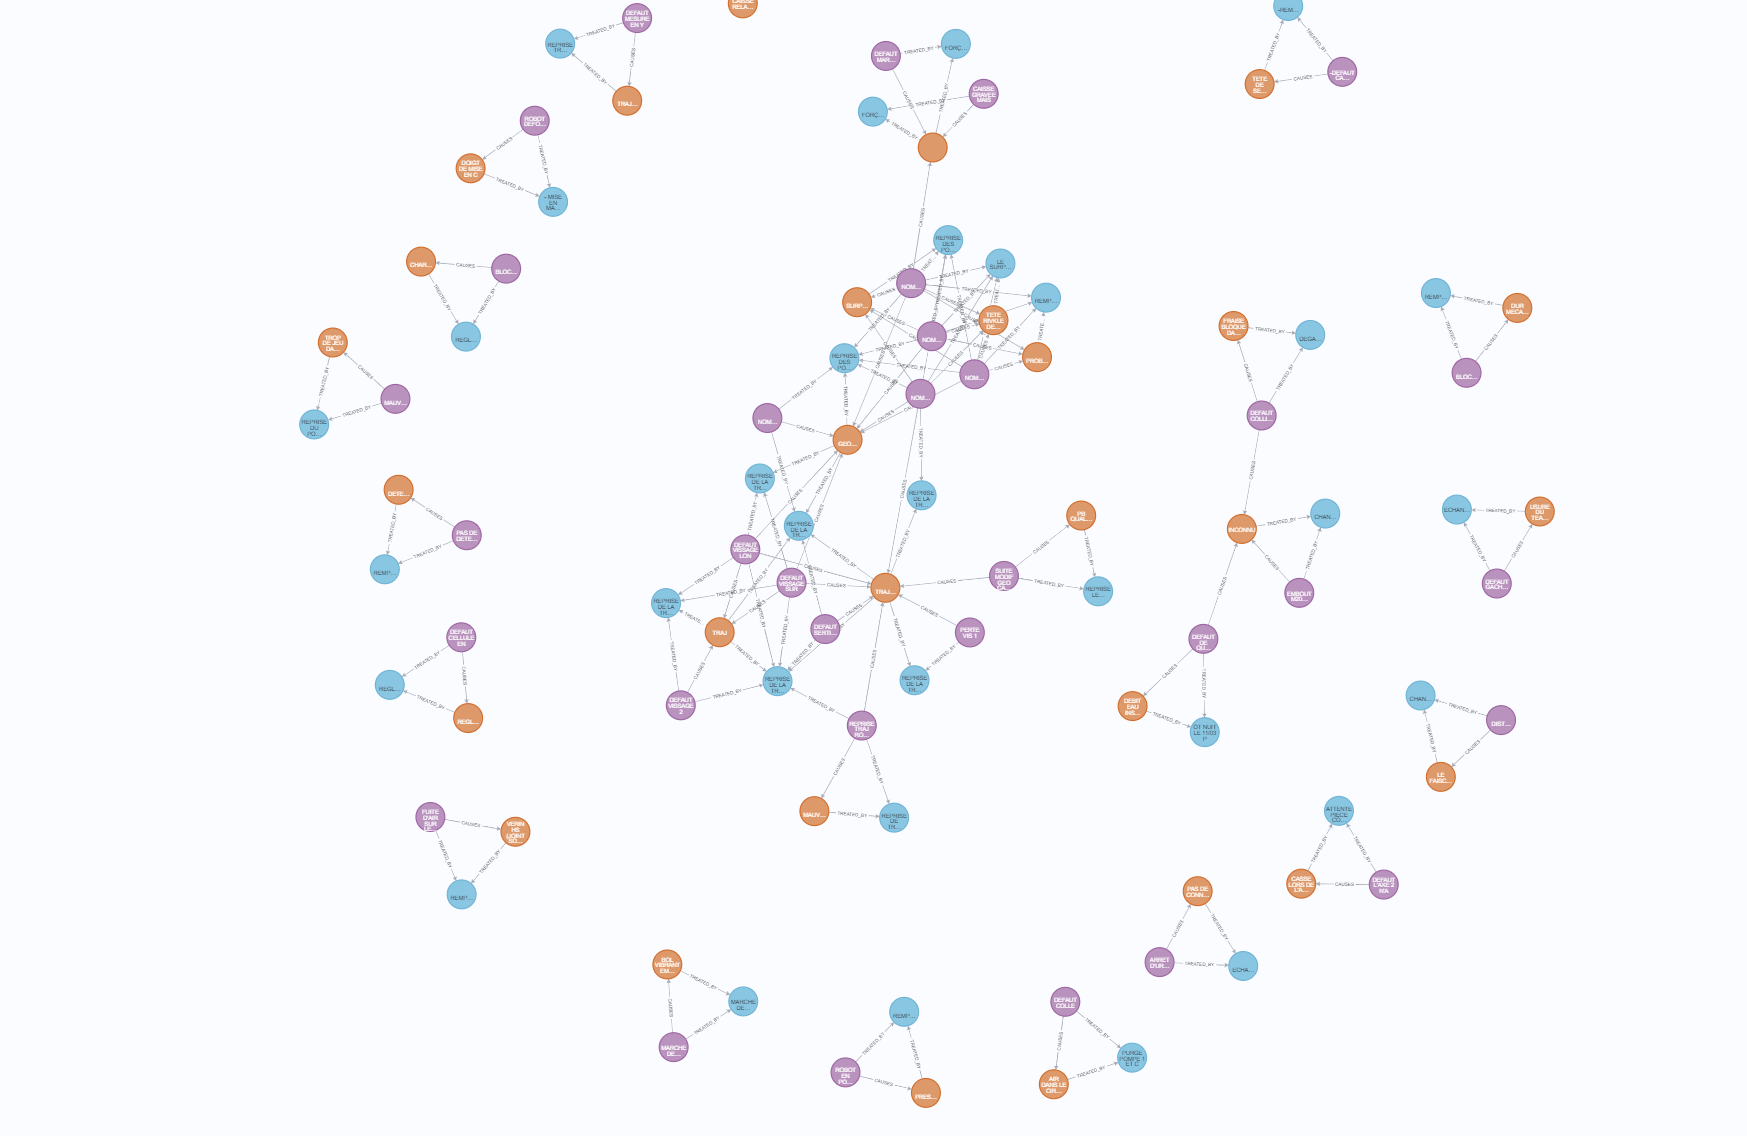

After the creation of the graph and it's enrichement we will be creating an index store. The retrieved information from the vector index can then be used as context to the LLM so it can generate accurate and up-to-date answers.

In [38]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(uri, auth=(username, password))
with driver.session() as session:
    version = session.run("CALL dbms.components() YIELD versions RETURN versions[0] AS version").single()["version"]
    print(f"Neo4j version: {version}")  # Should be ≥5.11.0

Neo4j version: 5.17.0


In [39]:
#creating the vector database
from langchain.vectorstores.neo4j_vector import Neo4jVector

model="all-MiniLM-L6-v2"
embbedings= HuggingFaceBgeEmbeddings(model_name=model)

vector_index = Neo4jVector.from_existing_graph(
    embedding=embbedings,
    url=uri,
    username=username,
    password=password,
    index_name='symptomes',
    node_label="Symptome",
    text_node_properties=['name'],
    embedding_node_property='embedding',
)

In [46]:
# response you get from the vector database

response = vector_index.similarity_search(
    "il ya probleme de soudure ",
    k=2,
)
print(response[0].page_content)
print(response[1].page_content)



name:  PAS DE SOUDURE 

name:  PAS SOUDURE 


In [ ]:
# from the retreived symptomes from the vector database we can get the cause and solution from the graph database
def get_cause_solution(symptom_name):
    with driver.session(database="renault") as session:
        # More flexible query that handles partial matches and checks for existence
        result = session.run("""
            MATCH (s:Symptome) 
            WHERE toLower(s.name) CONTAINS toLower($symptom_name)
            OPTIONAL MATCH (s)-[:CAUSES]->(c:Cause)
            OPTIONAL MATCH (s)-[:TREATED_BY]->(r:Solution)
            RETURN s.name as symptome, 
                   COALESCE(c.name, 'Unknown cause') as cause, 
                   COALESCE(r.name, 'Unknown solution') as solution
            LIMIT 5
        """, symptom_name=symptom_name)
        
        
        record = result
        causes=[]
        solutions=[]
        for record in result:
            causes.append(record["cause"])
            solutions.append(record["solution"])
        set_causes=set(causes)
        set_solutions=set(solutions)
        if record:
            return {"causes": set_causes, "solutions": set_solutions}  # Return as dictionary for easier handling
        return {"symptom": symptom_name, "cause": "Not found", "solution": "Not found"}

In [77]:
print(response[0].page_content[8:])
print(get_cause_solution(response[0].page_content[8:]))
print(response[1].page_content[8:])
print(get_cause_solution(response[1].page_content[8:]))


PAS DE SOUDURE 
{'causes': {' MANQUE AEVR ', 'TRESSE HS ', ' AJOUT D UNE LIGNE  SMT    ', ' PAS DE LIAISON AVEC AUTOMATE ', ' PERTE RESEAU ENTRE B3 ET API '}, 'solutions': {' CONTROLE ENVOI CODE CYCLE API -  ROBOT OK  POWER OFF  ROBOT NOK COUPURE BAIE OK '}}
PAS SOUDURE 
{'causes': {' PIECE POLLUEE ', ' AJOUT D UNE LIGNE  SMT    ', ' PAS DE LIAISON AVEC AUTOMATE ', ' PERTE RESEAU ENTRE B3 ET API ', ":PAS D'INTENSITE    "}, 'solutions': {' REBOOT ARMOIRE IBOX : NOK  400V  FAIT INIT NOK COUPURE 400 24V : OK INIT PINCE RELANCE OK '}}
